# TD Deep Q-Network

# Tutorial - Deep Q-Learning 

Deep Q-Learning uses a neural network to approximate $Q$ functions. Hence, we usually refer to this algorithm as DQN (for *deep Q network*).

The parameters of the neural network are denoted by $\theta$. 
*   As input, the network takes a state $s$,
*   As output, the network returns $Q_\theta [a | s] = Q_\theta (s,a) = Q(s, a, \theta)$, the value of each action $a$ in state $s$, according to the parameters $\theta$.


The goal of Deep Q-Learning is to learn the parameters $\theta$ so that $Q(s, a, \theta)$ approximates well the optimal $Q$-function $Q^*(s, a) \simeq Q_{\theta^*} (s,a)$. 

In addition to the network with parameters $\theta$, the algorithm keeps another network with the same architecture and parameters $\theta^-$, called **target network**.

The algorithm works as follows:

1.   At each time $t$, the agent is in state $s_t$ and has observed the transitions $(s_i, a_i, r_i, s_i')_{i=1}^{t-1}$, which are stored in a **replay buffer**.

2.  Choose action $a_t = \arg\max_a Q_\theta(s_t, a)$ with probability $1-\varepsilon_t$, and $a_t$=random action with probability $\varepsilon_t$. 

3. Take action $a_t$, observe reward $r_t$ and next state $s_t'$.

4. Add transition $(s_t, a_t, r_t, s_t')$ to the **replay buffer**.

4.  Sample a minibatch $\mathcal{B}$ containing $B$ transitions from the replay buffer. Using this minibatch, we define the loss:

$$
L(\theta) = \sum_{(s_i, a_i, r_i, s_i') \in \mathcal{B}}
\left[
Q(s_i, a_i, \theta) -  y_i
\right]^2
$$
where the $y_i$ are the **targets** computed with the **target network** $\theta^-$:

$$
y_i = r_i + \gamma \max_{a'} Q(s_i', a', \theta^-).
$$

5. Update the parameters $\theta$ to minimize the loss, e.g., with gradient descent (**keeping $\theta^-$ fixed**): 
$$
\theta \gets \theta - \eta \nabla_\theta L(\theta)
$$
where $\eta$ is the optimization learning rate. 

6. Every $N$ transitions ($t\mod N$ = 0), update target parameters: $\theta^- \gets \theta$.

7. $t \gets t+1$. Stop if $t = T$, otherwise go to step 2.

In [1]:
# Imports
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from copy import deepcopy
import gym
from gym.wrappers import Monitor
import matplotlib.pyplot as plt
from tqdm import tqdm

# from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output
from pathlib import Path
import base64

Explaination : 

gym.wrappers : Wrappers will allow us to add functionality to environments, such as modifying observations and rewards to be fed to our agent.
Get familiar with an agent’s activity

In [2]:
print(f"python --version = {sys.version}")
print(f"torch.__version__ = {torch.__version__}")
print(f"np.__version__ = {np.__version__}")
print(f"gym.__version__ = {gym.__version__}")

python --version = 3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]
torch.__version__ = 1.10.0+cpu
np.__version__ = 1.21.4
gym.__version__ = 0.21.0


## Torch 101

>"The torch package contains data structures for multi-dimensional tensors and defines mathematical operations over these tensors. Additionally, it provides many utilities for efficient serializing of Tensors and arbitrary types, and other useful utilities. 
[...] provides classes and functions implementing automatic differentiation of arbitrary scalar valued functions." 
[PyTorch](https://pytorch.org/docs/stable/index.html)


### Variable types

In [3]:
# Very similar syntax to numpy.
zero_torch = torch.zeros((3, 2))

print('zero_torch is of type {:s}'.format(str(type(zero_torch))))

# Torch -> Numpy: simply call the numpy() method.
zero_np = np.zeros((3, 2))
assert (zero_torch.numpy() == zero_np).all()

# Numpy -> Torch: simply call the corresponding function on the np.array.
zero_torch_float = torch.FloatTensor(zero_np)
print('\nFloat:\n', zero_torch_float)
zero_torch_int = torch.LongTensor(zero_np)
print('Int:\n', zero_torch_int)
zero_torch_bool = torch.BoolTensor(zero_np)
print('Bool:\n', zero_torch_bool)

# Reshape
print('\nView new shape...', zero_torch.view(1, 6))
# Note that print(zero_torch.reshape(1, 6)) would work too.
# The difference is in how memory is handled (view imposes contiguity).

# Algebra
a = torch.randn((3, 2))
b = torch.randn((3, 2))
print('\nAlgebraic operations are overloaded:\n', a, '\n+\n', b, '\n=\n', a+b )

# More generally, torch shares the syntax of many attributes and functions with Numpy.

zero_torch is of type <class 'torch.Tensor'>

Float:
 tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
Int:
 tensor([[0, 0],
        [0, 0],
        [0, 0]])
Bool:
 tensor([[False, False],
        [False, False],
        [False, False]])

View new shape... tensor([[0., 0., 0., 0., 0., 0.]])

Algebraic operations are overloaded:
 tensor([[ 0.6805, -0.4974],
        [ 0.0243, -1.8017],
        [ 1.7573, -1.3667]]) 
+
 tensor([[ 1.3637,  0.1474],
        [ 0.8756,  0.8590],
        [ 0.6741, -0.5296]]) 
=
 tensor([[ 2.0442, -0.3500],
        [ 0.8999, -0.9427],
        [ 2.4314, -1.8963]])


### Gradient management

In [4]:
# torch.Tensor is a similar yet more complicated data structure than np.array.
# It is basically a static array of number but may also contain an overlay to 
# handle automatic differentiation (i.e keeping track of the gradient and which 
# tensors depend on which).
# To access the static array embedded in a tensor, simply call the detach() method
print(zero_torch.detach())

# When inside a function performing automatic differentiation (basically when training 
# a neural network), never use detach() otherwise meta information regarding gradients
# will be lost, effectively freezing the variable and preventing backprop for it. 
# However when returning the result of training, do use detach() to save memory 
# (the naked tensor data uses much less memory than the full-blown tensor with gradient
# management, and is much less prone to mistake such as bad copy and memory leak).

# We will solve theta * x = y in theta for x=1 and y=2
x = torch.ones(1)
y = 2 * torch.ones(1)

# Actually by default torch does not add the gradient management overlay
# when declaring tensors like this. To force it, add requires_grad=True.
theta = torch.randn(1, requires_grad=True)

# Optimisation routine
# (Adam is a sophisticated variant of SGD, with adaptive step).
optimizer = optim.Adam(params=[theta], lr=0.1)

# Loss function
print('Initial guess:', theta.detach())

for _ in range(100):
    # By default, torch accumulates gradients in memory.
    # To obtain the desired gradient descent beahviour,
    # just clean the cached gradients using the following line:
    optimizer.zero_grad()
    
    # Quadratic loss (* and ** are overloaded so that torch
    # knows how to differentiate them)
    loss = (y - theta * x) ** 2
    
    # Apply the chain rule to automatically compute gradients
    # for all relevant tensors.
    loss.backward()
    
    # Run one step of optimisation routine.
    optimizer.step()
    
print('Final estimate:', theta.detach())
print('The final estimate should be close to', y)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
Initial guess: tensor([-0.6853])
Final estimate: tensor([1.9925])
The final estimate should be close to tensor([2.])


## Setting the environment

### 1 - Define the GLOBAL parameters

In [5]:
# Environment
env = gym.make("CartPole-v0")

# Discount factor
GAMMA = 0.99

# Batch size
BATCH_SIZE = 256
# Capacity of the replay buffer
BUFFER_CAPACITY = 16384 # 10000
# Update target net every ... episodes
UPDATE_TARGET_EVERY = 5 # 20

# Initial value of epsilon
EPSILON_START = 1.0
# Parameter to decrease epsilon
DECREASE_EPSILON = 200
# Minimum value of epislon
EPSILON_MIN = 0.05

# Number of training episodes
N_EPISODES = 200 

# Learning rate
LEARNING_RATE = 0.1

Obtenir des informations sur l'environnement

env.action_space.n

obs_size = env.observation_space.shape[0]


### 2 - Replay buffer

In [8]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, reward, next_state):
        """Saves a transition."""
        #print(self.memory, 'memory avant')
        if len(self.memory) < self.capacity:
            self.memory.append(None)
            #print(self.memory, 'memory dans le if')
        self.memory[self.position] = (state, action, reward, next_state)
        #print(self.memory, 'memory après')
        #print(self.position, ' position avant')
        self.position = (self.position + 1) % self.capacity
        #print(self.position, 'position après')

    def sample(self, batch_size):
        return random.choices(self.memory, k=batch_size)

    def __len__(self):
        return len(self.memory)

# create instance of replay buffer
#replay_buffer = ReplayBuffer(3)

### 3 - Neural Network

In [9]:
class Net(nn.Module):
    """
    Basic neural net.
    """
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x)

### 3.5 - Loss function and optimizer

In [10]:
# create network and target network
hidden_size = 128
obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n

q_net = Net(obs_size, hidden_size, n_actions)
target_net = Net(obs_size, hidden_size, n_actions)

# objective and optimizer
objective = nn.MSELoss()
optimizer = optim.Adam(params=q_net.parameters(), lr=LEARNING_RATE)

In [11]:
def reset():
    """Reset the model and all."""
    global q_net, target_net, replay_buffer, optimizer
    q_net = Net(obs_size, hidden_size, n_actions)
    target_net = Net(obs_size, hidden_size, n_actions)
    replay_buffer = ReplayBuffer(BUFFER_CAPACITY)
    optimizer = optim.Adam(params=q_net.parameters(), lr=LEARNING_RATE)
    torch.manual_seed(666)
    np.random.seed(666)
reset()

### Question 0 (to do at home, not during the live session)

With your own word, explain the intuition behind DQN. Recall the main parts of the aformentionned algorithm.

## Implementing the DQN

In [12]:
def get_q(states, network = 'q_net'):
    """
    Compute Q function for a list of states
    """
    with torch.no_grad():
        states_v = torch.FloatTensor([states])
        if network == 'q_net' : 
            output = q_net.forward(states_v).detach().numpy()  # shape (1, len(states), n_actions)
        elif network == 'target_net':
           output = target_net.forward(states_v).detach().numpy()  # shape (1, len(states), n_actions)
    return output[0, :, :]  # shape (len(states), n_actions)

Examples

states = [[1,2,3,4], [5,8,9,0]] #Chaque état a deux actions possibles 


Q = get_q(states)

#### Question 1

Implement the `choose_action` function.

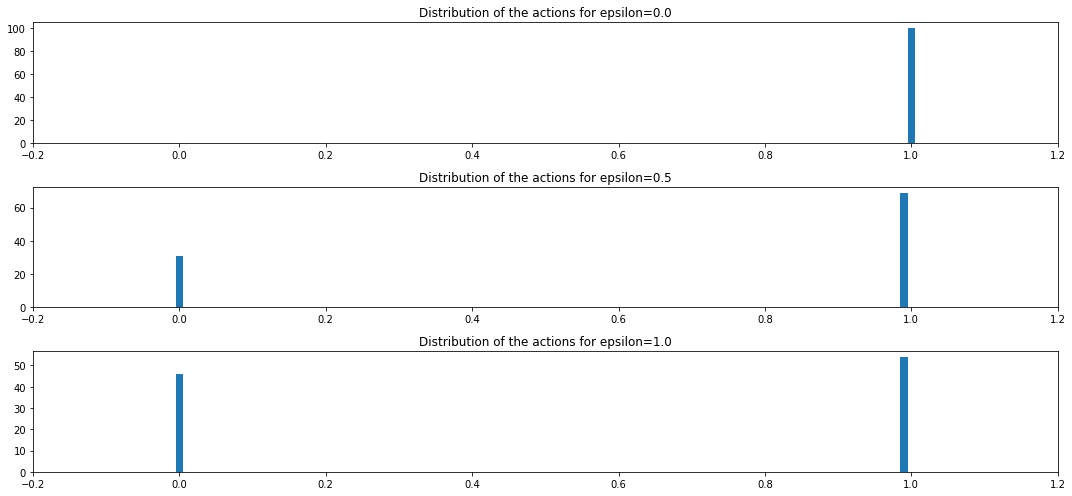

In [13]:
sample_states = [[0. for i in range(obs_size)] for _ in range(4)]

def choose_action(state, epsilon):
    """    
    Return action according to an epsilon-greedy exploration policy
    """
    Q = get_q([state])
    p = np.random.uniform(0,1)
    if p > epsilon: 
        best_action = torch.argmax(torch.FloatTensor(Q), axis=-1).numpy()[0]
    else : 
        best_action = random.randint(0, env.action_space.n -1)
    return(best_action)

#Test Question 1
epsilon_values = [0., 0.5, 1.]
fig, axes = plt.subplots(len(epsilon_values), 1, figsize=(15, 7))
for ax, epsilon in zip(axes, epsilon_values):
    actions = []
    for _ in range(100):
        actions.append(choose_action(sample_states[0], epsilon))
    ax.hist(actions, align="left", bins=100);
    ax.set_title(f"Distribution of the actions for {epsilon=}")
    ax.set_xlim(-0.2, 1.2)
plt.tight_layout()

#### Question 2

Implement the `eval_dqn` function.

In [14]:
def eval_dqn(n_sim=5):
    """    
    Monte Carlo evaluation of DQN agent.

    Repeat n_sim times:
        * Run the DQN policy until the environment reaches a terminal state (= one episode)
        * Compute the sum of rewards in this episode
        * Store the sum of rewards in the episode_rewards array.
    """
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    for i in range (0,n_sim):
        s = env_copy.reset()
        done = False
        sim_r = 0
        while not done:
            a = choose_action(s, 0.)
            s_next, r, done, info = env_copy.step(a)
            episode_rewards[i] += r
            s = s_next  
    return episode_rewards
N = 10
eval_result = eval_dqn(N)
assert eval_dqn(N).shape == (N,) #test unitaire : raise une error si c'est faux
#assert np.mean(eval_result)<20
print(eval_result)

[30. 59. 25. 34. 28. 57. 39. 27. 59. 79.]


C:\Users\magal\AppData\Local\Temp/ipykernel_12720/3106486662.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  states_v = torch.FloatTensor([states])


#### Question 3

Implement the `update` function

In [15]:
def update(state, action, reward, next_state, done, verbose=False):
    """
    ** TO BE COMPLETED **
    """
    
    # add data to replay buffer
    if done:
        next_state = None
    replay_buffer.push(state, action, reward, next_state)
    
    if len(replay_buffer) < BATCH_SIZE:
        return np.inf
    
    # get batch
    transitions = replay_buffer.sample(BATCH_SIZE)  # BATCH_SIZE * line (state, action, reward, next_state)

    states = [x[0] for x in transitions]
    actions = [x[1] for x in transitions]
    rewards = [x[2] for x in transitions]

    next_states = [x[3] for x in transitions if isinstance(x[3], np.ndarray)]

    next_states_mask = [isinstance(x[3], np.ndarray) for x in transitions] 
    #print("states", states)


    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions).view(-1, 1)
    rewards = torch.FloatTensor(rewards).view(-1, 1)
    next_states = torch.FloatTensor(next_states)
    mask = torch.BoolTensor(next_states_mask)

    # Compute loss - 
    values  = q_net(states) # Shape (nbr_states, nbr_actions)
    values = torch.gather(values, dim=1, index=actions) # We retrieve the Q(s,a) for the selected action a
    if verbose:
        print("Values:", values.shape)

    # Compute the target
    values_next_states = torch.zeros(BATCH_SIZE)
    values_next_states[mask] = target_net(next_states).max(dim=1)[0].detach()

    targets = rewards + GAMMA * values_next_states.view(-1, 1)   # to be computed using batch
    if verbose:
        print("target", targets.shape)
    
    loss = objective(values, targets)
     
    # Optimize the model - UNCOMMENT!
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.detach().numpy()

#### Question 4
Train a DQN on the `env` environment.
*Hint* The mean reward after training should be close to 200.

In [32]:
EVAL_EVERY = 3
REWARD_THRESHOLD = 199

def train(verbose:bool = True):
    state = env.reset()
    epsilon = EPSILON_START
    ep = 0
    total_time = 0
    losses = []
    rewards_history = []
    while ep < N_EPISODES:
        action = choose_action(state, epsilon)

        # take action and update replay buffer and networks
        next_state, reward, done, _ = env.step(action)
        loss = update(state, action, reward, next_state, done)
        losses.append(loss)
        # update state
        state = next_state

        # end episode if done
        if done:
            state = env.reset()
            ep   += 1
            if ( (ep+1)% EVAL_EVERY == 0):
                rewards = eval_dqn()
                rewards_history.append(np.mean(rewards))
                #print("episode =", ep+1, ", reward = ", np.mean(rewards))
                if np.mean(rewards) >= REWARD_THRESHOLD:
                    break

            # update target network
            if ep % UPDATE_TARGET_EVERY == 0:
                target_net.load_state_dict(q_net.state_dict())
            # decrease epsilon
            epsilon = EPSILON_MIN + (EPSILON_START - EPSILON_MIN) * \
                            np.exp(-1. * ep / DECREASE_EPSILON )    

        total_time += 1
    return ep, losses, rewards_history


# Run the training loop
reset()
train()

# Evaluate the final policy
rewards = eval_dqn(20)
print("")
print("mean reward after training = ", np.mean(rewards))


mean reward after training =  158.7


#### Question 5

Experiment the policy network.

(Showing a video with a jupyter notebook, you may try this cell with Chrome/Chromium instead of Firefox. Otherwise, you may skip this question.)

In [17]:
video_folder = "./videos"
env = Monitor(env, './videos', force=True, video_callable=lambda episode: True)

for episode in range(1):
    done = False
    state = env.reset()
    while not done:
        action = choose_action(state, 0.0)
        state, reward, done, info = env.step(action)
env.close()

from IPython.display import Video
import os
from glob import glob
Video(glob(os.path.join(video_folder,"*.mp4"))[0])
# show_video()

C:\Users\magal\AppData\Local\Programs\Python\Python38\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Impossible de modifier le mode thread une fois qu’il a été fixé
  warnings.warn(str(err))


### Experiments: Do It Yourself

In [33]:
#Remember the set of global parameters:

# Environment
env = gym.make("CartPole-v0")

# Discount factor
GAMMA = 0.99

# Batch size
BATCH_SIZE = 256
# Capacity of the replay buffer
BUFFER_CAPACITY = 16384 # 10000
# Update target net every ... episodes
UPDATE_TARGET_EVERY = 32 # 20

# Initial value of epsilon
EPSILON_START = 1.0
# Parameter to decrease epsilon
DECREASE_EPSILON = 200
# Minimum value of epislon
EPSILON_MIN = 0.05

# Number of training episodes
N_EPISODES = 200

# Learning rate
LEARNING_RATE = 0.1

In [34]:
def run_one():
    """Run once the training and evaluation of the model."""
    reset()
    result = {}
    result['episode_takens'], losses, rewards_history = train(verbose=False)
    result['score'] = np.mean(eval_dqn())
    result['losses'] = losses
    result['rewards'] = rewards_history
    return result

#### Question 6

Craft an experiment and study the influence of the `BUFFER_CAPACITY` on the learning process (speed of *convergence*, training curves...) 

In [35]:
#result est une liste de dictionnaire avec chaque liste est un dico d'une valeur de buffer capacity
previous_value = BUFFER_CAPACITY


nbr_values = 4
nbr_each = 2
results = []
with tqdm(total=nbr_values*nbr_each, desc="Compute the influence", colour="green") as pbar:
    for i in np.linspace(500, 100000, nbr_values):
        BUFFER_CAPACITY = int(i)
        for _ in range(nbr_each):
            results.append({
                "Buffer Capacity": BUFFER_CAPACITY,
                **run_one()
            })
            pbar.update()

Compute the influence: 100%|█████████████████████████████████████████████████████████████████| 8/8 [01:34<00:00, 11.83s/it]


In [36]:
import pandas as pd
df = pd.DataFrame.from_records(results)
BUFFER_CAPACITY = previous_value
df.head()

,Buffer Capacity,episode_takens,score,losses,rewards
0,500,200,27.2,"[inf, inf, inf, inf, inf, inf, inf, inf, inf, ...","[9.8, 9.6, 9.4, 9.6, 9.2, 10.4, 9.6, 9.6, 13.6..."
1,500,200,33.8,"[inf, inf, inf, inf, inf, inf, inf, inf, inf, ...","[9.2, 9.4, 9.4, 9.2, 9.8, 11.6, 9.4, 10.6, 11...."
2,33666,200,105.0,"[inf, inf, inf, inf, inf, inf, inf, inf, inf, ...","[9.2, 9.2, 9.2, 9.6, 12.0, 10.2, 9.4, 12.2, 9...."
3,33666,200,66.2,"[inf, inf, inf, inf, inf, inf, inf, inf, inf, ...","[9.8, 10.0, 9.6, 9.6, 9.2, 9.8, 9.2, 9.6, 10.4..."
4,66833,200,99.6,"[inf, inf, inf, inf, inf, inf, inf, inf, inf, ...","[9.4, 9.0, 9.0, 9.6, 9.4, 9.4, 10.6, 9.8, 10.4..."


#dataframe qui contient la colonne losses
reset index permet de créer une colonne index
force les losses en float
pour un buffer d
l'index correspond a chaque update

In [37]:
new_df = []
for _, row in df.iterrows():
    x = pd.DataFrame({'losses' : row.losses}).reset_index()
    x['buffer'] = str(row["Buffer Capacity"])
    x['losses'] = x['losses'].astype(float)
    new_df.append(x)
new_df = pd.concat(new_df, ignore_index = True)
new_df.head(3)

,index,losses,buffer
0,0,inf,500
1,1,inf,500
2,2,inf,500


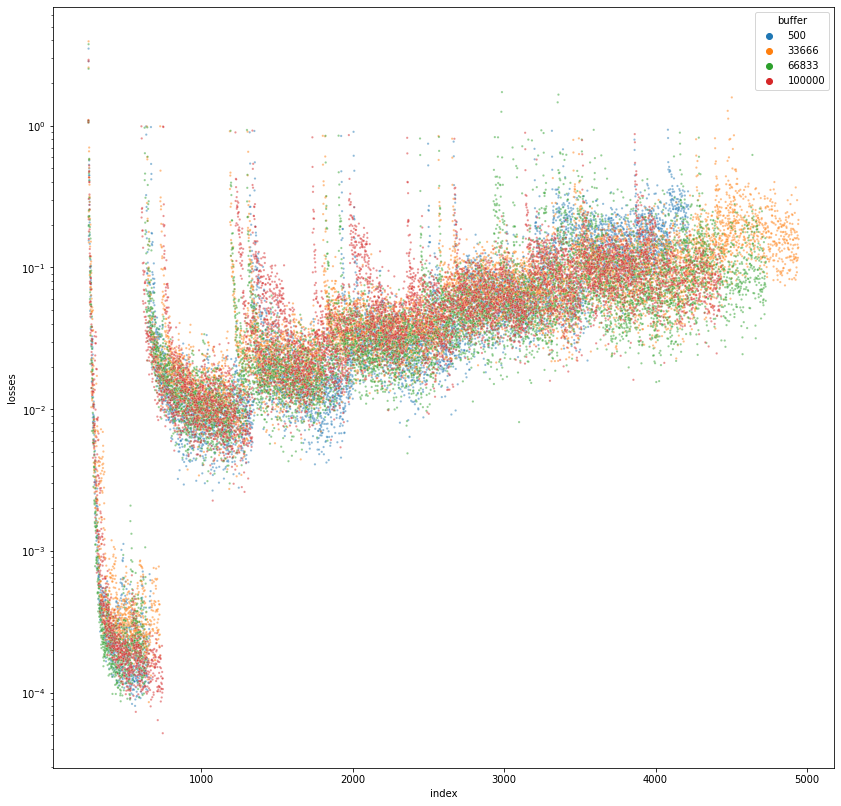

In [38]:
import seaborn as sns
plt.figure(figsize=(14, 14))
sns.scatterplot(data=new_df, x="index", y="losses", hue="buffer", alpha=0.5, s=5)
plt.yscale('log')

TODO : rajouter une interpretation du graphique

#### Question 7

Craft an experiment and study the influence of the `UPDATE_TARGET_EVERY` on the learning process (speed of *convergence*, training curves...) 

In [39]:
previous_value = UPDATE_TARGET_EVERY

nbr_values = 4
nbr_each = 2
results_update_target = []
with tqdm(total=nbr_values*nbr_each, desc="Compute the influence", colour="green") as pbar:
    for i in np.linspace(1, 21, nbr_values):
        UPDATE_TARGET_EVERY = int(i)
        for _ in range(nbr_each):
            results_update_target.append({
                "UPDATE_TARGET_EVERY": UPDATE_TARGET_EVERY,
                **run_one()
            })
            pbar.update()
            
UPDATE_TARGET_EVERY = previous_value


Compute the influence: 100%|█████████████████████████████████████████████████████████████████| 8/8 [01:16<00:00,  9.54s/it]


In [42]:
df_update_target = pd.DataFrame.from_records(results_update_target)

new_df_update_target = []
for _,row in df_update_target.iterrows():
    x = pd.DataFrame({'losses' : row.losses}).reset_index()
    x['update_every'] = str(row['UPDATE_TARGET_EVERY'])
    x['losses']=x['losses'].astype(float)
    new_df_update_target.append(x)
    
new_df_update_target = pd.concat(new_df_update_target, ignore_index=True)
new_df_update_target.head(3)

,index,losses,update_every
0,0,inf,1
1,1,inf,1
2,2,inf,1


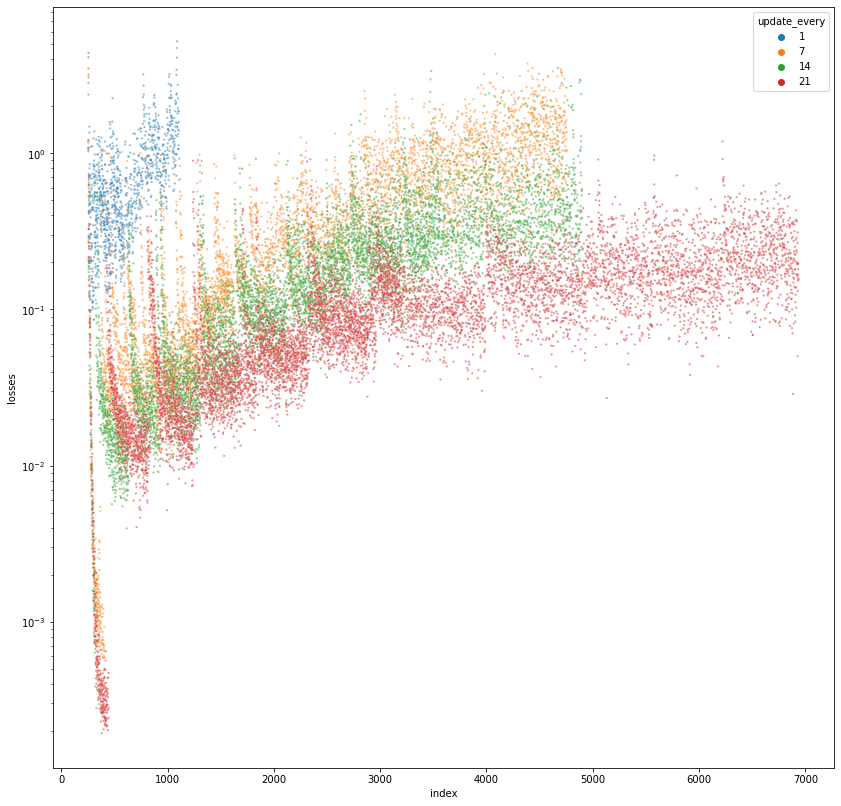

In [44]:
plt.figure(figsize=(14, 14))
sns.scatterplot(data=new_df_update_target, x="index", y="losses", hue="update_every", alpha=0.5, s=5)
plt.yscale('log')

TODO :Interprétation du résultat

#### Question 8

If you have the computer power to do so, try to do a grid search on those two hyper-parameters and comment the results. Otherwise, study the influence of another hyper-parameter.

In [47]:
previous_value = BATCH_SIZE

nbr_values = 4
nbr_each = 2
results_batch_size = []
with tqdm(total=nbr_values*nbr_each, desc="Compute the influence", colour="green") as pbar:
    for i in np.linspace(100, 1000, nbr_values):
        BATCH_SIZE = int(i)
        for _ in range(nbr_each):
            results_batch_size.append({
                "BATCH_SIZE": BATCH_SIZE,
                **run_one()
            })
            pbar.update()
            
BATCH_SIZE = previous_value

Compute the influence: 100%|█████████████████████████████████████████████████████████████████| 8/8 [01:21<00:00, 10.14s/it]


In [48]:
df_batch_size = pd.DataFrame.from_records(results_batch_size)

new_df_batch_size = []
for _,row in df_batch_size.iterrows():
    x = pd.DataFrame({'losses' : row.losses}).reset_index()
    x['batch_size'] = str(row['BATCH_SIZE'])
    x['losses']=x['losses'].astype(float)
    new_df_batch_size.append(x)
    
new_df_batch_size = pd.concat(new_df_batch_size, ignore_index=True)
new_df_batch_size.head(3)

,index,losses,batch_size
0,0,inf,100
1,1,inf,100
2,2,inf,100


In [50]:
plt.figure(figsize=(14, 14))
sns.scatterplot(data=new_df, x="index", y="losses", hue="batch_size", alpha=0.5, s=5)
plt.yscale('log')

ValueError: Could not interpret value `batch_size` for parameter `hue`

<Figure size 1008x1008 with 0 Axes>

## Discretization

It is natural to use a function approximator like a neural network to approximate the $Q$ function in a continuous environment. Another natural but unscalable way to do handle continuous state-action space is **discretization**.

Discretize the environment of your choice (cartpole or mountain car or both) and run one of the algorithms that you know to compute an approximation of the optimal $Q$ function.

Once you are satisfied with your results, you may plot the *optimal phase diagram* of the system. For instance, you may get something like this for the mountain car environment.
![Phase diagram](./phase_plot.png)

In [ ]:
# TODO: Everything! This is an introduction to research and development